# 认知建模基础作业4

In [1]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

### 1 Bayesian Factor
在全部题目均为判断题的考试中，共有100道题目，答对0-59道题目为`不及格(F)`，答对60-84道题目为`及格(B)`，答对85-100道题目为`优秀(A)`，同学 $X$ 前三次考试均为`及格(B)`，第四、五次考试成绩为`不及格(F)`，假设同学 $X$ 的能力 $\theta$ （即做对每一道题的概率，不同题目是否做对是独立的，不同考试之间不发生改变）的先验是 $U(0, 1)$。

1) 请你将成绩视作删失数据（censored data 可参考课上Cha Sa soon的例子），用MCMC采样（本题为保证结果稳定请采样不少于10000次）的方法，报告同学 $X$ 能力的后验分布，并基于后验分布，给出如果该同学额外参加一次考试，成绩为`优秀(A)` `及格(B)` `不及格(F)`概率的后验预测分布（10分）。

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta]
>Metropolis: [new]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 42 seconds.


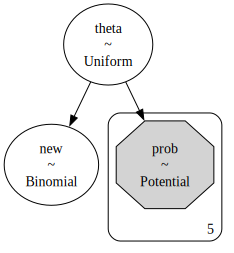

In [7]:
result = np.array([1, 1, 1, 0, 0])
with pm.Model() as ExamX:
    theta = pm.Uniform('theta', lower = 0, upper = 1)
    pB = pt.log(pt.exp(pm.Binomial.logcdf(84, 100, theta)) - pt.exp(pm.Binomial.logcdf(59, 100, theta)))
    pC = pm.Binomial.logcdf(59, 100, theta)
    prob = pm.Potential('prob', pt.switch(result, pB, pC))
    new = pm.Binomial('new', n = 100, p = theta)
    trace_exam = pm.sample(10000)
pm.model_to_graphviz(ExamX)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
new,60.690,5.631,49.000,70.00,0.073,0.043,5916.0,8956.0,1.0
theta,0.607,0.028,0.556,0.66,0.000,0.000,9752.0,18167.0,1.0


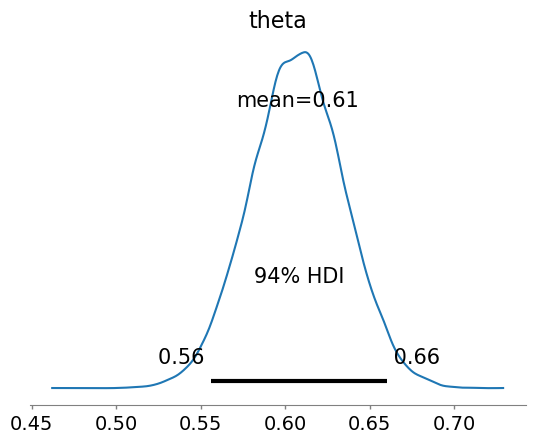

In [8]:
az.plot_posterior(trace_exam, var_names=['theta'])
az.summary(trace_exam)

In [9]:
new = trace_exam.posterior['new'].values.flatten()
print(f'F: {np.mean(new <60)*100:.2f}%, B: {(np.mean(new < 85) - np.mean(new < 60))*100:.2f}%, A: {np.mean(new > 84)*100:.2f}%')

F: 41.44%, B: 58.56%, A: 0.00%


2) 有两个模型可以解释同学 $X$ 的行为，$\mathcal{H}_0: \theta = 0.5$ 和 $\mathcal{H}_1:\theta \sim U(0, 1)$，对于这样的嵌套模型，我们可以用Savage-Dickey方法估计贝叶斯因子，具体做法是，在 $\mathcal{H}_1$的假设下进行MCMC采样后，使用参数 $\theta$ 的先验分布和后验分布计算：$$BF_{01} = \frac{p(\mathcal{D}|\mathcal{H}_0)}{p(\mathcal{D}|\mathcal{H}_1)} = \frac{p(\theta = 0.5|\mathcal{D},\mathcal{H}_1)}{p(\theta = 0.5|\mathcal{H}_1)}$$其中先验分布（分母）可以直接获得，而后验分布（分子）可以对采样样本进行平滑（如直方图或者高斯核估计等）得到，请你自行查阅资料，解释算得贝叶斯因子对两个假设的支持程度（10分）。

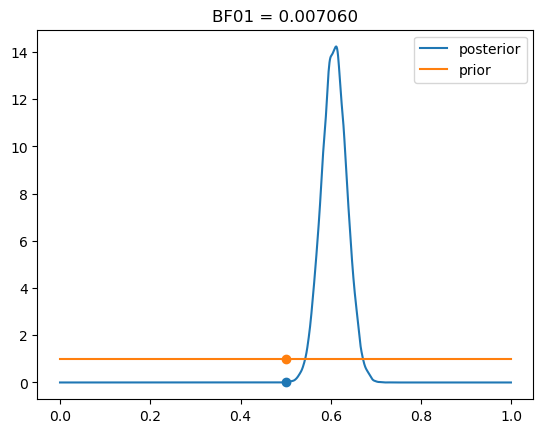

In [14]:
theta = trace_exam.posterior['theta'].values.flatten()
kde_theta = gaussian_kde(theta)
x = np.arange(0, 1, 0.001)
plt.plot(x, kde_theta(x), label = 'posterior')
plt.scatter(0.5, kde_theta(0.5))
plt.plot(x, [1]*len(x), label = 'prior')
plt.scatter(0.5, 1)
plt.title(f'BF01 = {kde_theta(0.5).item():.6f}')
plt.legend() #BF < .01, 非常强的证据支持H1

3) 对于先验的选择，$\mathcal{H}_2: \theta\sim U(0.5, 1)$ 可能更加合理，请你预测使用在这一先验下贝叶斯因子 $BF_{02}$ 相比 $BF_{01}$ 如何改变（你可以选择修改模型后重新采样的结果，或者使用 $\mathcal{H}_1$的结果通过数值计算估计新的贝叶斯因子的值，10分）

In [11]:
# 直接计算
kde_theta(0.5) / np.mean(theta >= 0.5) /2

array([0.00353027])

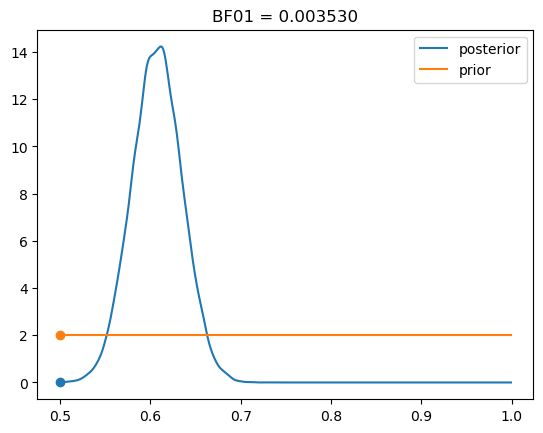

In [13]:

theta = trace_exam.posterior['theta'].values.flatten()
kde_theta = gaussian_kde(theta)
x = np.arange(0.5, 1, 0.001)
plt.plot(x, kde_theta(x)/np.mean(theta >=0.5), label = 'posterior')
plt.scatter(0.5, kde_theta(0.5)/np.mean(theta >=0.5))
plt.plot(x, [2]*len(x), label = 'prior')
plt.scatter(0.5, 2)
plt.title(f'BF01 = {kde_theta(0.5).item()/np.mean(theta >=0.5)/2:.6f}')
plt.legend() #BF < .01, 非常强的证据支持H2（比H1更强）

## 2 Bayesian Model Selection

在本题目中，我们希望通过一个现实情形的类比，帮助大家理解贝叶斯模型选择的概念。某中心的老师希望探究 $A$ 同学的课堂参与情况，有两个模型进行解释：
- $\mathcal{M}_1$：该同学是**出席者**；
- $\mathcal{M}_0$：该同学是**缺席者**。

检验模型的数据为 $A$ 同学在16周课程中的签到情况 $\mathcal{D} = \{\mathcal{D}_i\in\{0, 1\}\}_{i=1}^{16}$：`1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0`，其中`1`表示签到成功，`0`表示签到失败。我们对模型证据作出如下假定：出席者签到成功的概率为99%，而缺席者签到成功的概率为40%，不同观测之间独立。即模型证据函数为：$$\begin{align*}
p(\mathcal{D}_i|\mathcal{M}_1) = 
\begin{cases}
0.99, \text{ if } \mathcal{D}_i = 1\\
0.01, \text{ if } \mathcal{D}_i = 0
\end{cases}\\
p(\mathcal{D}_i|\mathcal{M}_0) = 
\begin{cases}
0.4, \text{ if } \mathcal{D}_i = 1\\
0.6, \text{ if } \mathcal{D}_i = 0
\end{cases}
\end{align*}$$

1) 固定效应假说：该模型假设 $A$ 同学要么是**出席者**（$\mathcal{M}_1$）要么是**缺席者**（$\mathcal{M}_0$），在整个学期不会发生改变。请分别计算似然函数 $p(\mathcal{D}|\mathcal{M}_1)$  和 $p(\mathcal{D}|\mathcal{M}_0)$，并报告按照最大似然法选择的可以解释 $A$ 同学行为的模型（5分）；

In [15]:
data = np.array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0])
counts = np.bincount(data)
p_D_M1 = 0.01 ** counts[0] * 0.99 ** counts[1]
p_D_M0 = 0.6 ** counts[0] * 0.4 ** counts[1]
p_D_M1, p_D_M0 # p_D_M1 < p_D_M0, MLE结果认为A是缺席者

(8.77521022998968e-07, 1.4495514624000007e-06)

2) 在固定效应假说基础上，我们假定 $A$ 同学是出席者的概率为 $p(\mathcal{M}_1) = \theta$, 而 $\theta$ 的先验概率为 $[0, 1]$ 均匀分布，请画出图模型，并通过**MCMC**采样报告 $\theta$ 的后验分布和后验期望（5分）；

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta]
>BinaryGibbsMetropolis: [identity]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.461,0.289,0.002,0.924,0.006,0.002,2522.0,3368.0,1.0


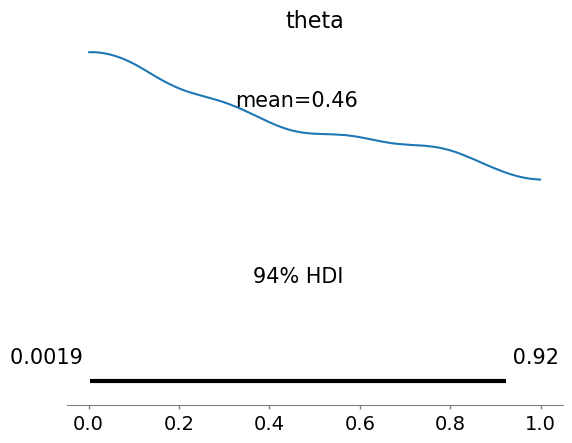

In [16]:
with pm.Model() as AbsentFixEffect:
    theta = pm.Uniform('theta', lower = 0, upper = 1)
    identity = pm.Bernoulli('identity', p = theta)
    p1 = pt.switch(identity, 0.99, 0.4)
    sign = pm.Bernoulli('sign', p = p1, observed = data)
    trace_absentfix = pm.sample(2000)
pm.model_to_graphviz(AbsentFixEffect)
az.plot_posterior(trace_absentfix, var_names=['theta'])
az.summary(trace_absentfix, var_names=['theta'])


3) 随机效应假说：该模型假设 $A$ 同学每节课前都会随机“选择”成为**出席者**（$\mathcal{M}_1$）或者**缺席者**（$\mathcal{M}_0$）。具体来讲， $A$ 同学成为出席者的先验概率是 $r\sim U(0, 1)$，隐变量 $z_i \sim Bernoulli(r)$ 表示每节课的状态（1对应出席者，0对应缺席者）。画出图模型，并通过MCMC采样报告 $r$ 的后验分布和后验期望，同时报告哪那些周 $A$ 同学更可能缺席了课程（5分）；

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [r]
>BinaryGibbsMetropolis: [z]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.64,0.166,0.328,0.923,0.005,0.003,1180.0,1940.0,1.0


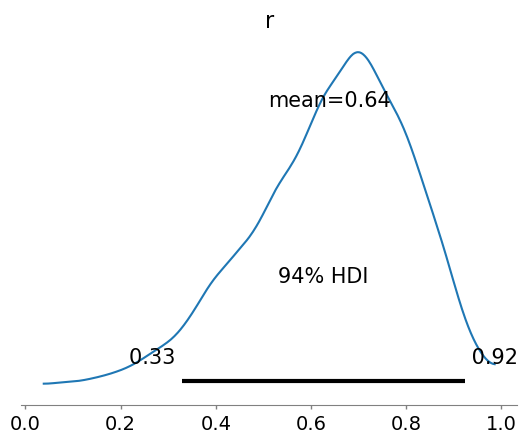

In [17]:
with pm.Model() as AbsentRandomEffect:
    r = pm.Uniform('r', lower = 0, upper = 1)
    z = pm.Bernoulli('z', p = r, shape = len(data))
    p1 = pt.switch(z, 0.99, 0.4)
    # p0 = pt.switch(identity, 0.1, 0.8)
    sign = pm.Bernoulli('sign', p = p1, observed = data)
    trace_absentrand = pm.sample(2000)
pm.model_to_graphviz(AbsentRandomEffect)
az.plot_posterior(trace_absentrand, var_names=['r'])
az.summary(trace_absentrand, var_names=['r']) #多数课程A还是出息的

In [18]:
az.summary(trace_absentrand) #这是很明显的，3 13 16三周

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z[0],0.800,0.400,0.000,1.000,0.006,0.004,5085.0,5085.0,1.0
z[1],0.796,0.403,0.000,1.000,0.006,0.004,4577.0,4577.0,1.0
z[2],0.044,0.206,0.000,0.000,0.003,0.006,5820.0,5820.0,1.0
z[3],0.796,0.403,0.000,1.000,0.006,0.004,4992.0,4992.0,1.0
z[4],0.794,0.405,0.000,1.000,0.006,0.004,4650.0,4650.0,1.0
z[5],0.789,0.408,0.000,1.000,0.006,0.004,4539.0,4539.0,1.0
z[6],0.806,0.396,0.000,1.000,0.006,0.005,4449.0,4449.0,1.0
z[7],0.804,0.397,0.000,1.000,0.006,0.004,4863.0,4863.0,1.0
z[8],0.789,0.408,0.000,1.000,0.006,0.004,5099.0,5099.0,1.0
z[9],0.798,0.402,0.000,1.000,0.006,0.004,4819.0,4819.0,1.0


4) 在随机效应模型下，除了用 $r$ 的后验期望表示 $A$ 同学每节课前成为**出席者**的平均概率，我们还可以近似计算出席者模型$(\mathcal{M}_1)$的胜出概率（probability of exceedance)，其定义是：$$\phi_1 = p(r > 1 - r|\mathcal{D}) = \int_{0.5}^1 p(r|\mathcal{D})dr$$我们可以用**MCMC**采样结果中 $r > 0.5$ 的比例进行近似，请估计 $\mathcal{M}_1$ 的胜出概率（5分）

In [20]:
(trace_absentrand.posterior['r'].values > 0.5).mean()  # 其实这是很小的胜出概率

0.800375

5) 下面我们考虑现实的模型比较问题，假设现在有 $\mathcal{M_1}$ 和 $\mathcal{M}_0$ 两个模型，分别对16名被试的数据进行逐被试的拟合得到两组AIC指标`AIC1`和`AIC0`，数据存储在`aic.csv`中，我们可以用AIC指标对模型证据进行近似：$$\begin{align*}
\log p(\mathcal{D}_i|M_0) = -\frac12AIC_0[i])\\\log p(\mathcal{D}_i|M_1) = -\frac12AIC_1[i])\\\end{align*}$$除此之外均与2-4问中图模型结构一致，请你仿照2-4问的做法，（1）在固定效应假说下采样模型得到 $\theta$ 的后验分布和后验期望；（2）在随机效应假说下采样模型得到 $r$ 的后验分布和后验期望，并报告模型 $M_1$ 的胜出概率。（你可能需要用到pm.Potential函数，它接收的值应该是对数概率，10分）

In [23]:
data = pd.read_csv('aic.csv')
AIC0 = data.AIC0
AIC1 = data.AIC1

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta]
>BinaryGibbsMetropolis: [identity]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.
/Users/zhangxuyang/miniconda3/envs/pymc5/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.331,0.235,0.0,0.744,0.004,0.002,3027.0,3342.0,1.0


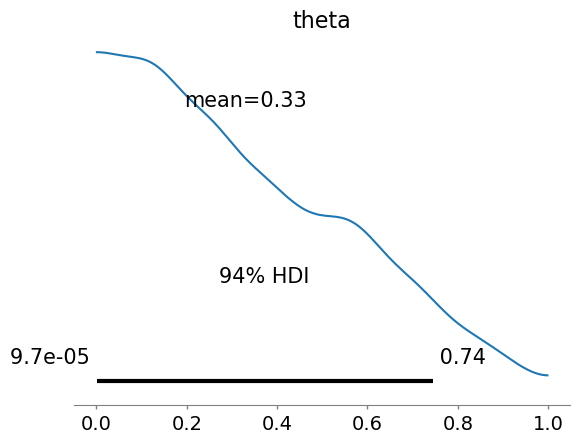

In [79]:
with pm.Model() as AICFixEffect:
    theta = pm.Uniform('theta', lower = 0, upper = 1)
    identity = pm.Bernoulli('identity', p = theta)
    AIC = AIC1 * identity + (1 - identity) * AIC0
    evidence = pm.Potential('evidence', -0.5 * AIC)
    trace_AICfix = pm.sample(2000)
pm.model_to_graphviz(AICFixEffect)
az.plot_posterior(trace_AICfix, var_names=['theta'])
az.summary(trace_AICfix, var_names=['theta'])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta]
>BinaryGibbsMetropolis: [identity]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.
/Users/zhangxuyang/miniconda3/envs/pymc5/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.82,0.093,0.647,0.968,0.002,0.001,2747.0,3396.0,1.0


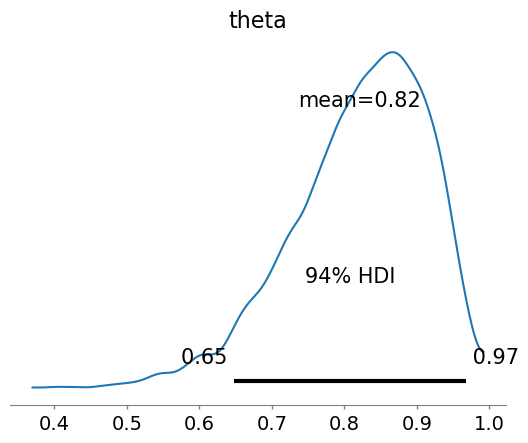

In [80]:
with pm.Model() as AICRandomEffect:
    theta = pm.Uniform('theta', lower = 0, upper = 1)
    identity = pm.Bernoulli('identity', p = theta, shape = len(AIC1))
    AIC = AIC1 * identity + (1 - identity) * AIC0
    evidence = pm.Potential('evidence', -0.5 * AIC)
    trace_AICrand = pm.sample(2000)
pm.model_to_graphviz(AICFixEffect)
az.plot_posterior(trace_AICrand, var_names=['theta'])
az.summary(trace_AICrand, var_names=['theta'])

In [81]:
(trace_AICrand.posterior['theta'].values > 0.5).mean()

0.996875

6) 结合上面两个具体的例子，解释在固定效应和随机效应两种假设下，进行模型比较时会得到不同结果的可能原因，你认为在模型比较中更应该采用哪种思路？（5分）

## Case Study
## 3.Hierarchical Latent Mixture Model
在`homework3`中，我们引入了`Coffee or Beer`这样一道题目，题目内容如下：

>在一项食品研究中，研究人员想要区分两类专业人士的口味偏好：
>- **咖啡师**：专长于咖啡的风味、烘焙程度、酸度等；
>- **酿酒师**：专长于啤酒的苦度、麦芽风味、酒精发酵工艺等。
>
>咖啡师给咖啡评分($\alpha_0$)比啤酒分数($\beta_0$)更高，而酿酒师给啤酒评分($\alpha_1$)比咖啡分数更高($\beta_1$)。同时咖啡师给分极差更大($\beta_0$ < $\beta_1$ <$\alpha_1$ < $\alpha_0$)。在实际拟合数据时，**我们发现可能还存在第三类人：跨界专家**。他们是研究食品风味的科学家，对不同风味有自己研究，对啤酒和咖啡并无给分高低之分，但由于见多识广,评分($\theta$)不高不低($\beta_0$ < $\beta_1$ < $\theta$ < $\alpha_1$ < $\alpha_0$)
>
>**另外，值得注意的是，第一名rater是酿酒师**，**第一杯饮料是咖啡**。在本题目中，**分数范围是0-100的连续值**。

上面的建模却忽略了个体差异，**比如不同咖啡师给咖啡打分均值和标准差可能也是不同的**。在这道题目中，我们利用**分层贝叶斯建模**，即考虑群体差异同时考虑个体差异，在上述假设基础上，本题增加额外假设如下：

>- **不同群体对不同饮料给分均值 $\mu$** ：服从以下关系($\beta_0$ < $\beta_1$ < $\theta$ < $\alpha_1$ < $\alpha_0$)，处于同一群体的不同个体对同一类别饮料给分均值相同。
>- **不同群体对饮料给分幅度均值 $\overline\sigma_i$**：由于酒精的作用，酿酒师给分相对来说比较随意，其对于饮品给分幅度均值($\overline\sigma_1$)相对较大，大于等于咖啡师给分幅度均值($\overline\sigma_0$)和跨界专家给分均值($\overline\sigma_2$)，也即($\overline\sigma_0 \leq \overline\sigma_1$， $\overline\sigma_2 \leq \overline\sigma_1$)。同时 $0 < \overline\sigma_1 < 5$。
>- **每名个体给分幅度 $\sigma_j$**： 服从高斯分布，均值为个体所在群体给分幅度均值$\overline\sigma_i$，标准差为定值 $0.1$，例如对某位酿酒师：$\sigma_j \sim \mathcal{N}(\overline\sigma_1, 0.1^2)$，并且同一个体对不同饮料给分幅度相同（即同一个个体给咖啡或者啤酒的标准差没有差异）；
>- 每名个体 $j$ 给不同饮料的评分均服从高斯分布 $\mathcal{N}(\mu, \sigma_j^2)$。

本题数据储存在`cb.csv`中，可参考课件中`6.2 Exam scores with individual differences`代码进行作答：

1) 请你根据本题目的假设写出模型并绘制出概率图模型(5分)

In [3]:
# load data
data = pd.read_csv('./cb.csv')
data.head(5)

,drinks0,drinks1,drinks2,drinks3,drinks4,drinks5,rater
0,42.20,75.70,78.02,39.70,86.42,44.17,0
1,42.27,80.61,76.90,37.53,76.86,39.74,1
2,66.39,72.14,70.07,69.67,69.34,73.20,2
3,96.82,25.70,25.00,97.77,25.09,97.07,3
4,69.87,68.09,67.33,70.12,67.95,71.59,4


In [5]:
drinks = 5
columns = [f'drinks{i}' for i in range(drinks)]
scores = data[columns].values
n, drinks = scores.shape

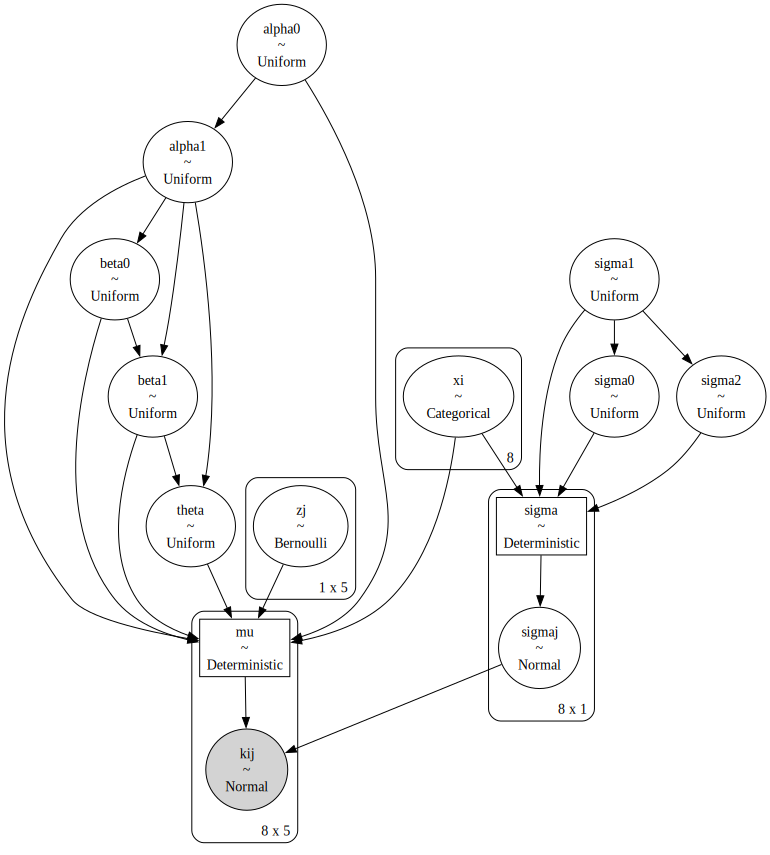

In [57]:
# set model
with pm.Model() as model1:
    # population mu
    alpha0 = pm.Uniform('alpha0', lower=0., upper=100)
    alpha1 = pm.Uniform('alpha1', lower=0., upper=alpha0)
    beta0 = pm.Uniform('beta0', lower=0., upper=alpha1)
    beta1 = pm.Uniform('beta1', lower=beta0, upper=alpha1)
    theta = pm.Uniform('theta', lower=beta1, upper=alpha1)
    
    # population sigma
    sigma1 = pm.Uniform('sigma1', lower=0., upper=5)
    sigma2 = pm.Uniform('sigma2', lower=0., upper=sigma1)
    sigma0 = pm.Uniform('sigma0', lower=0., upper=sigma1)
    
    # 设置 xi 和 zj
    xi_probs = np.vstack([[0, 1, 0]] + [[1/3, 1/3, 1/3]] * (n - 1))
    xi_probs = pt.as_tensor_variable(xi_probs)
    xi = pm.Categorical('xi', p=xi_probs, shape=(n,))
    xi = xi[:, None]
    
    # 设置第一个饮品是0
    zj = pm.Bernoulli("zj", p=[0]+[0.5]*(drinks-1), shape=(1, drinks))
    
    
    # 设置参数 theta，使用嵌套的 pt.switch 进行二重判定
    mu = pm.Deterministic('mu',
        pt.switch(
        pt.eq(xi, 2),
        theta,
        pt.switch(
            pt.eq(xi, zj),
            pt.switch(pt.eq(xi, 0), alpha0, alpha1),
            pt.switch(pt.eq(xi, 0), beta0, beta1)
        )
    ))
    
    sigma = pm.Deterministic('sigma',
        pt.switch(
        pt.eq(xi, 2),
        sigma2,
        pt.switch(
            pt.eq(xi, 0),
            sigma0, sigma1
        )
    ))
    sigmaj = pm.Normal('sigmaj', mu=sigma, sigma=0.1)
    
    kij = pm.Normal('kij', mu=mu, sigma=sigmaj, observed=scores)

pm.model_to_graphviz(model1)

2) `homework3`题目`coffee or beer`中`h2`的概率图模型见附件`cb_h2.pdf`，请你比较和(1)中生成的概率图模型。请说明本题目中**群体差异**和**个体差异**是如何在概率图模型中体现(5分)

- 群体差异，根据xi与zj是否相等，给分均值有 $\alpha_0$,$\alpha_1$,$\beta_0$,$\beta_1$ 之分；根据xi的类别，不同类别人士给分幅度均值有$\sigma_0$,$\sigma_1$,$\sigma_2$区分

- 个体差异：由于被试间差异，不同个体给分受自己类别影响同时，还受给分噪音的影响，体现在$\sigma_j$彼此并不相同。

3) 请采用MCMC进行采样报告参数$\alpha_0$，$\alpha_1$，$\beta_0$，$\beta_1$，$\theta$，$\sigma_0$，$\sigma_1$, $\sigma_2$的期望并绘制出其对应的后验分布（10分)\[采样时请设置`tune=2000`,`random_seed=422`,`target_accept=0.9`\]

In [58]:
# sampling here
with model1:
    idata1 = pm.sample(tune=2000,random_seed=422,target_accept=0.9)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha0, alpha1, beta0, beta1, theta, sigma1, sigma2, sigma0, sigmaj]
>CategoricalGibbsMetropolis: [xi]
>BinaryGibbsMetropolis: [zj]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 23 seconds.
/opt/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [59]:
az.summary(idata1,var_names=['alpha0','alpha1','beta0','beta1','theta','sigma0',
                            'sigma1','sigma2'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha0,97.234,0.378,96.586,97.988,0.009,0.016,2522.0,1120.0,1.0
alpha1,79.757,1.189,77.474,81.970,0.025,0.022,2275.0,2055.0,1.0
beta0,25.163,0.291,24.613,25.718,0.004,0.007,5322.0,2962.0,1.0
beta1,40.663,1.449,38.141,43.570,0.025,0.028,3276.0,2320.0,1.0
theta,69.046,0.484,68.190,70.021,0.007,0.009,4385.0,2918.0,1.0
sigma0,0.685,0.235,0.313,1.130,0.008,0.009,1263.0,820.0,1.0
sigma1,3.528,0.594,2.559,4.722,0.018,0.010,1128.0,1140.0,1.0
sigma2,1.855,0.368,1.218,2.549,0.010,0.009,1608.0,1286.0,1.0


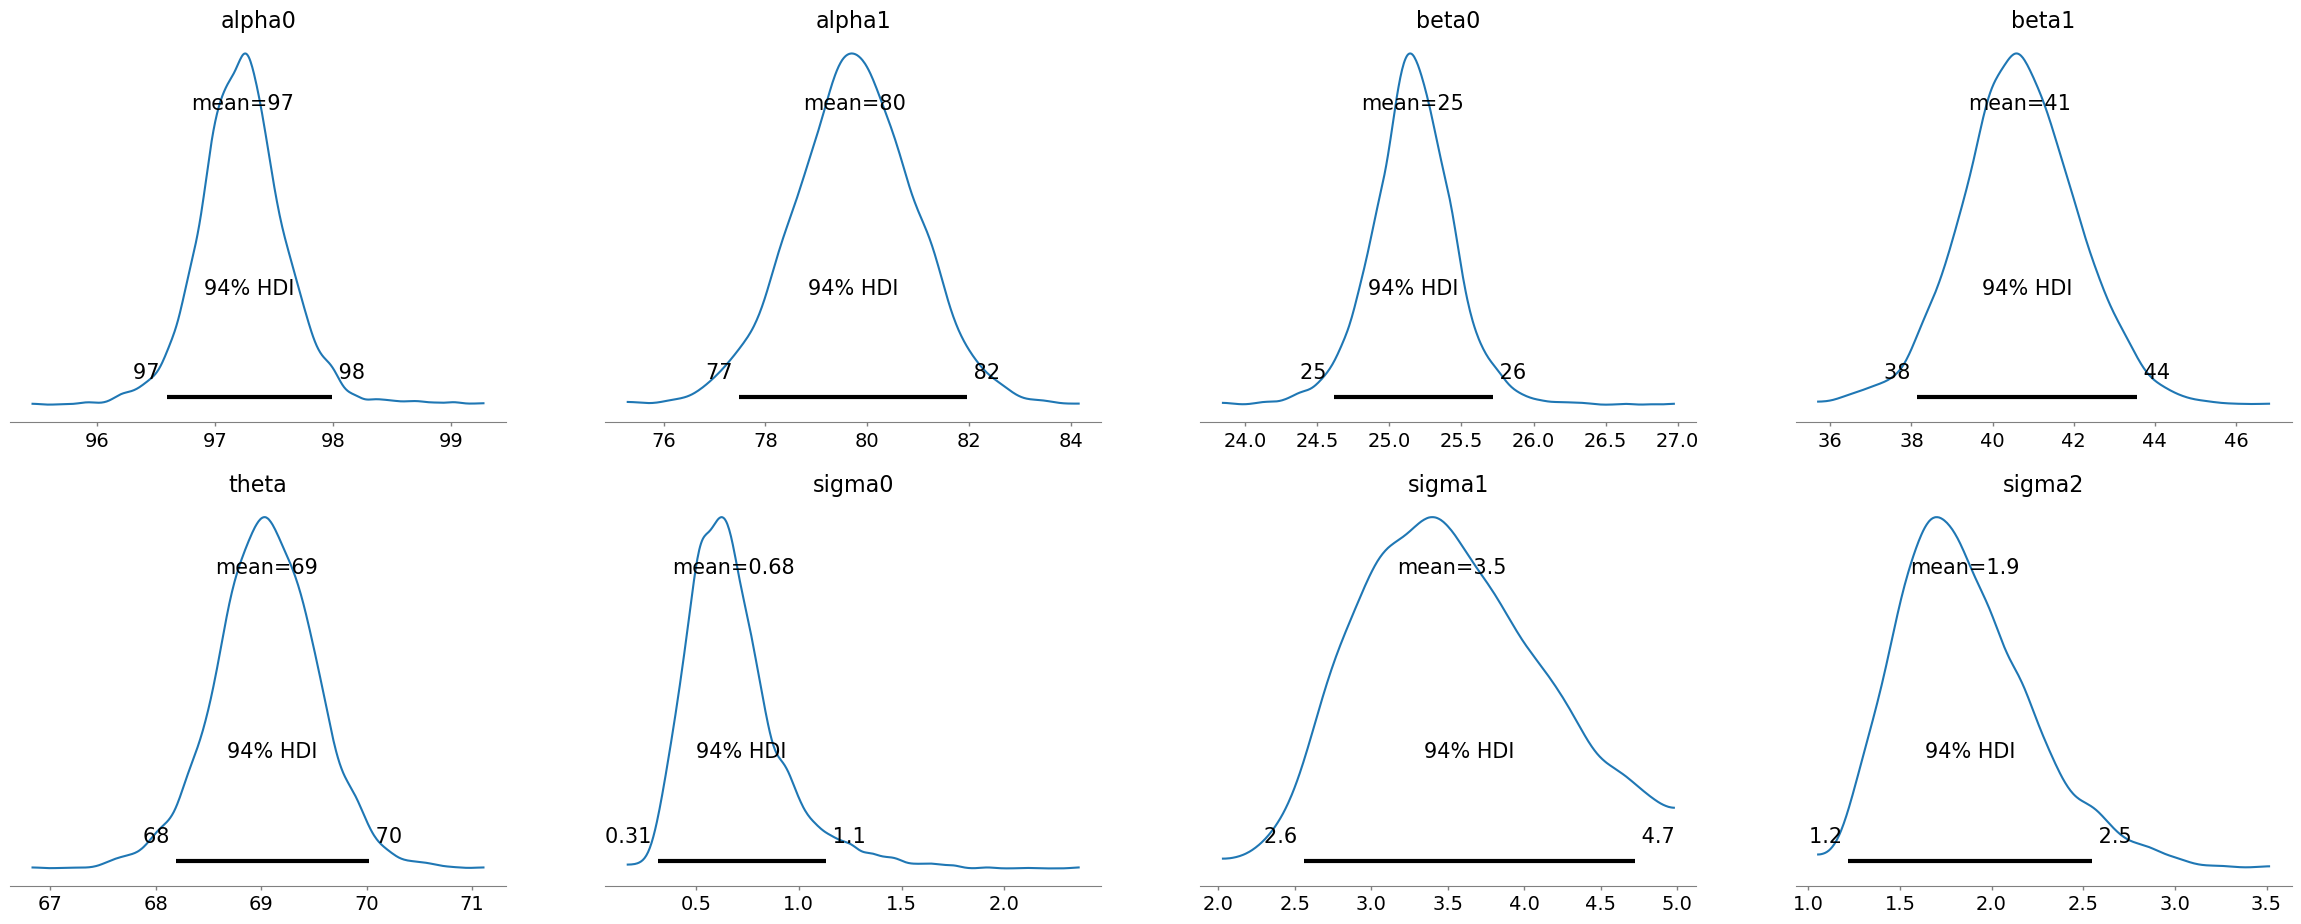

In [60]:
az.plot_posterior(idata1,var_names=['alpha0','alpha1','beta0','beta1','theta','sigma0',
                            'sigma1','sigma2'])
plt.show()

4) 利用(3)中的后验分布，请绘制出综合所有链与所有采样的$\sigma_j$的箱线图(5分)

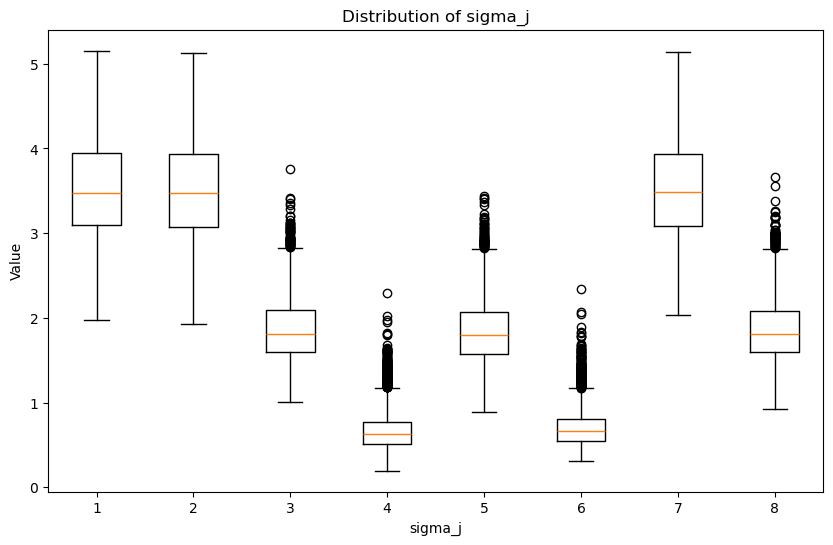

In [61]:
# 假设数据来自 trace2.posterior['sigmaj']
sigmaj = idata1.posterior['sigmaj']

# 重组数据维度并选择第一个 dim_1（索引为0）
sigmaj_reshaped = sigmaj.stack(sample=('chain', 'draw'))  
sigmaj_reshaped = sigmaj_reshaped.sel(sigmaj_dim_1=0)  
sigmaj_reshaped = sigmaj_reshaped.transpose('sample', 'sigmaj_dim_0')  

plt.figure(figsize=(10, 6))
plt.boxplot(sigmaj_reshaped)
plt.title('Distribution of sigma_j')
plt.ylabel('Value')
plt.xlabel('sigma_j')
plt.show()

5) 斯丢皮德认为，本题目的模型在理想采样情况下likelihood会不小于homework3中h2对应的理想采样结果对应的likelihood。**请问斯丢皮德说的是否正确？第三次作业中h2是否是本次作业模型的嵌套** (5分)

他的理由如下：
>从模型关系上来看，作业3中h2的假设对应的模型是本次作业假设对应模型的嵌套，homework3的h2对应的模型并未考虑到不同类别人群的群体差异以及群体内部的个体差异，而本次作业对应模型则考虑到这一点，因此表征能力更强。即使尚未存在群体差异与个体差异，本文对应模型在理想状态下对应参数也会收敛到作业3中h2到模型，因此本作业对应模型likelihood应该不小于上次作业模型的likelihood。

本次作业中的假设，如果没有$\sigma_s=0.1$的限制，确实如斯丢皮德所说，homework3中h2的假设是本作业的嵌套，但是因为$\sigma_s$ > 0，个人间的差异始终存在，本次作业模型不会收敛到homework3中的不同被试无差异的情况。

6) 如果我们没有**第一杯饮料是咖啡**这样的假设，请你重新进行采样，在`tune=2000`,`random_seed=422，target_accept=0.9`的情况下重新进行实验，请报告`xi`，`sigmaj`的r hat值，请问为什么会出现这样的情况(5分)

In [62]:
# 原来的模型
az.summary(idata1,var_names=['sigmaj'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"sigmaj[0, 0]",3.537,0.595,2.530,4.708,0.018,0.010,1121.0,1324.0,1.0
"sigmaj[1, 0]",3.526,0.602,2.495,4.698,0.018,0.011,1152.0,1131.0,1.0
"sigmaj[2, 0]",1.863,0.367,1.226,2.553,0.010,0.009,1659.0,1234.0,1.0
"sigmaj[3, 0]",0.669,0.238,0.307,1.121,0.008,0.009,1287.0,916.0,1.0
"sigmaj[4, 0]",1.842,0.378,1.190,2.571,0.010,0.008,1660.0,1314.0,1.0
"sigmaj[5, 0]",0.701,0.225,0.355,1.108,0.007,0.009,1315.0,892.0,1.0
"sigmaj[6, 0]",3.531,0.595,2.566,4.753,0.018,0.010,1144.0,1255.0,1.0
"sigmaj[7, 0]",1.861,0.372,1.258,2.607,0.010,0.009,1614.0,1288.0,1.0


In [54]:
# set model
with pm.Model() as model2:
    # population mu
    alpha0 = pm.Uniform('alpha0', lower=0., upper=100)
    alpha1 = pm.Uniform('alpha1', lower=0., upper=alpha0)
    beta0 = pm.Uniform('beta0', lower=0., upper=alpha1)
    beta1 = pm.Uniform('beta1', lower=beta0, upper=alpha1)
    theta = pm.Uniform('theta', lower=beta1, upper=alpha1)
    
    # population sigma
    sigma1 = pm.Uniform('sigma1', lower=0., upper=5)
    sigma2 = pm.Uniform('sigma2', lower=0., upper=sigma1)
    sigma0 = pm.Uniform('sigma0', lower=0., upper=sigma1)
    
    # 设置 xi 和 zj
    xi_probs = np.vstack([[0, 1, 0]] + [[1/3, 1/3, 1/3]] * (n - 1))
    xi_probs = pt.as_tensor_variable(xi_probs)
    xi = pm.Categorical('xi', p=xi_probs, shape=(n,))
    xi = xi[:, None]
    
    # 设置第一个饮品是0
    zj = pm.Bernoulli("zj", p=[0.5]+[0.5]*(drinks-1), shape=(1, drinks))
    
    
    # 设置参数 theta，使用嵌套的 pt.switch 进行二重判定
    mu = pm.Deterministic('mu',
        pt.switch(
        pt.eq(xi, 2),
        theta,
        pt.switch(
            pt.eq(xi, zj),
            pt.switch(pt.eq(xi, 0), alpha0, alpha1),
            pt.switch(pt.eq(xi, 0), beta0, beta1)
        )
    ))
    
    sigma = pm.Deterministic('sigma',
        pt.switch(
        pt.eq(xi, 2),
        sigma2,
        pt.switch(
            pt.eq(xi, 0),
            sigma0, sigma1
        )
    ))
    sigmaj = pm.Normal('sigmaj', mu=sigma, sigma=0.1)
    
    kij = pm.Normal('kij', mu=mu, sigma=sigmaj, observed=scores)

with model2:
    idata2 = pm.sample(tune=2000, random_seed=422, target_accept=0.9)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha0, alpha1, beta0, beta1, theta, sigma1, sigma2, sigma0, sigmaj]
>CategoricalGibbsMetropolis: [xi]
>BinaryGibbsMetropolis: [zj]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 23 seconds.
/opt/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [56]:
az.summary(idata2,var_names=['sigmaj','xi'])

/opt/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid v

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"sigmaj[0, 0]",4.000,0.971,2.700,5.565,0.412,0.163,7.0,29.0,1.53
"sigmaj[1, 0]",3.538,0.618,2.549,4.807,0.017,0.010,1345.0,1779.0,1.00
"sigmaj[2, 0]",1.883,0.391,1.232,2.615,0.012,0.010,1257.0,1210.0,1.00
"sigmaj[3, 0]",1.778,1.929,0.357,5.216,0.955,0.546,7.0,29.0,1.53
"sigmaj[4, 0]",1.863,0.405,1.203,2.667,0.012,0.010,1251.0,1281.0,1.00
"sigmaj[5, 0]",1.804,1.914,0.403,5.196,0.948,0.542,7.0,28.0,1.53
"sigmaj[6, 0]",3.546,0.614,2.527,4.782,0.017,0.010,1335.0,1765.0,1.00
"sigmaj[7, 0]",1.878,0.396,1.190,2.618,0.012,0.010,1215.0,1189.0,1.00
xi[0],1.000,0.000,1.000,1.000,0.000,NaN,4000.0,4000.0,NaN
xi[1],0.750,0.433,0.000,1.000,0.216,0.124,4.0,4.0,inf


会发现`xi`和`sigmaj`的r hat出现了大于1.01的情况，原因是缺少了这样的假设模型引入了更多的不确定性。影响了`xi`和`mu`的计算逻辑和一致性。通过固定第一个饮品为0，可以在模型设置中提供更清晰的决策依据，帮助模型更有效地探索参数空间并收敛(2分)